In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, accuracy_score, precision_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
from scipy.stats import ttest_rel, ttest_ind
from scipy import stats
from keras.layers import Input, GRU, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, MaxPooling1D, AveragePooling1D, Lambda, concatenate, Dense, Dropout
from keras.models import Model, load_model
from keras import backend as K
import tensorflow as tf
import cms_preprocess

2023-03-19 17:55:59.138743: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-19 17:55:59.183814: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Split the data into train and test sets
x_train, x_val, y_train, y_val, dv_train, dv_val, test_input, test_dv, test_target = cms_preprocess.get_mhe(cms_preprocess.ben_path,
  cms_preprocess.ip_path, cms_preprocess.pde_path, cms_preprocess.dx_path, cms_preprocess.pcs_path, cms_preprocess.ben_cols,
  cms_preprocess.ip_cols, cms_preprocess.pde_cols, rows=10000, start_year=2008, end_year=2010, random_state = 42, col_num=6)

/shared/orx/cms_preprocess.py:45: DtypeWarning: Columns (1,3,21) have mixed types. Specify dtype option on import or set low_memory=False.
  ben = pd.read_csv(ben_path, usecols=ben_cols)
/shared/orx/cms_preprocess.py:46: DtypeWarning: Columns (1,3,30) have mixed types. Specify dtype option on import or set low_memory=False.
  ip = pd.read_csv(ip_path, usecols=ip_cols)
/shared/orx/cms_preprocess.py:47: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  pde = pd.read_csv(pde_path, usecols=pde_cols)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replic

2023-03-19 18:00:11.021007: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-03-19 18:00:11.128803: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-19 18:00:11.129232: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x5601c066d110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-19 18:00:11.129243: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-03-19 18:00:11.132182: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-19 18:00:11.171565: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-19 18:00:11.19629

200/200 [==============================] - 8s 26ms/step - loss: 0.0426 - accuracy: 0.9936 - val_loss: 0.0392 - val_accuracy: 0.9937
Epoch 2/10
200/200 [==============================] - 4s 20ms/step - loss: 0.0374 - accuracy: 0.9936 - val_loss: 0.0351 - val_accuracy: 0.9937
Epoch 3/10
200/200 [==============================] - 4s 19ms/step - loss: 0.0325 - accuracy: 0.9936 - val_loss: 0.0367 - val_accuracy: 0.9937
Epoch 4/10
200/200 [==============================] - 4s 20ms/step - loss: 0.0261 - accuracy: 0.9936 - val_loss: 0.0331 - val_accuracy: 0.9937
Epoch 5/10
200/200 [==============================] - 4s 20ms/step - loss: 0.0241 - accuracy: 0.9942 - val_loss: 0.0392 - val_accuracy: 0.9937
Epoch 6/10
200/200 [==============================] - 4s 19ms/step - loss: 0.0200 - accuracy: 0.9944 - val_loss: 0.0332 - val_accuracy: 0.9950
Epoch 7/10
200/200 [==============================] - 4s 20ms/step - loss: 0.0179 - accuracy: 0.9950 - val_loss: 0.0394 - val_accuracy: 0.9937
Epoch 8/10

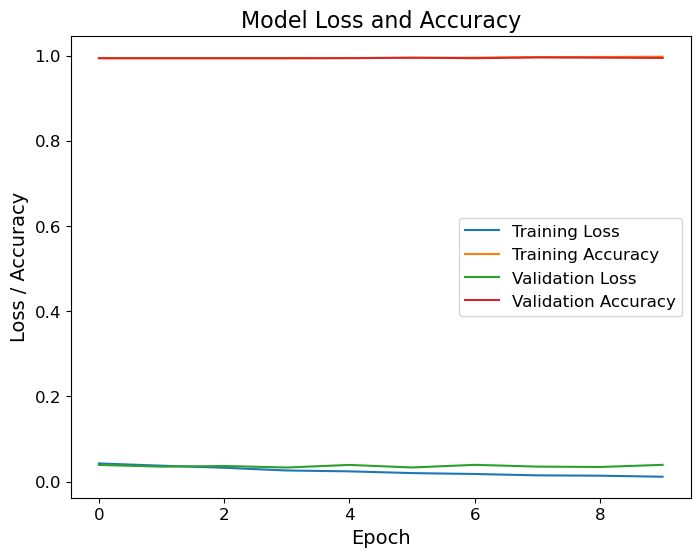

In [6]:
batch_size = 32
epochs=10

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    # Define the RNN model
    data_input = tf.keras.layers.Input(shape=(366, 516))  # input shape for non-demographic variables data
    dv_input = tf.keras.layers.Input(shape=(2,))  # input shape for demographic variables
    x = tf.keras.layers.GRU(200, return_sequences=True, dropout=0.2)(data_input)  # GRU layer with 200 hidden units and dropout rate of 0.2
    x_max = tf.keras.layers.GlobalMaxPooling1D()(x)  # max pooling over the time dimension
    x_avg = tf.keras.layers.GlobalAveragePooling1D()(x)  # average pooling over the time dimension
    x_min = tf.keras.layers.Lambda(lambda t: -1 * tf.keras.backend.max(-1 * t, axis=1))(x)  # min pooling over the time dimension
    x = tf.keras.layers.concatenate([x_max, x_avg, x_min])  # concatenate the pooled outputs
    x = tf.keras.layers.Dropout(0.2)(x)  # dropout layer to prevent overfitting
    concatenated = tf.keras.layers.concatenate([x, dv_input])  # concatenate the demographic variables with the pooled output
    output = tf.keras.layers.Dense(1, activation='sigmoid')(concatenated)  # dense, fully connected layer with a sigmoid activation
    model = tf.keras.Model(inputs=[data_input, dv_input], outputs=output)  # define the model with inputs and outputs

    # Compile the model with both the loss and accuracy metrics
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit((x_train, dv_train), y_train, epochs=epochs, batch_size=batch_size, validation_data=((x_val, dv_val), y_val))
    
    # Plot the loss and accuracy
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['accuracy'], label='Training Accuracy')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax.set_title('Model Loss and Accuracy', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('Loss / Accuracy', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
    plt.show()


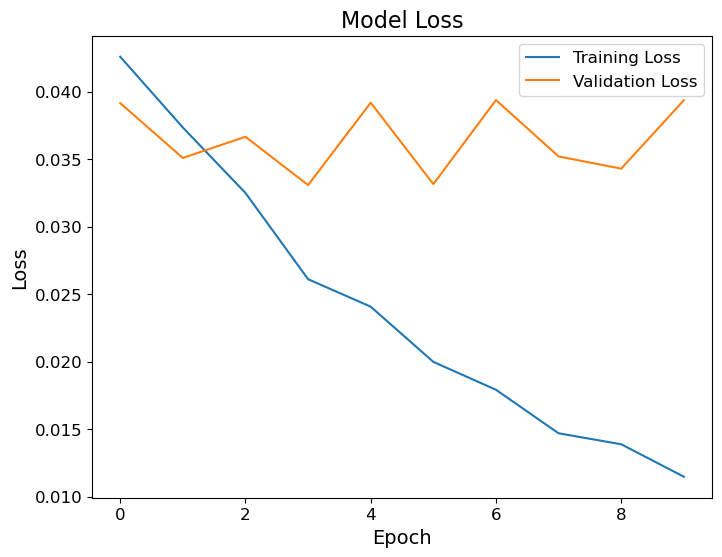

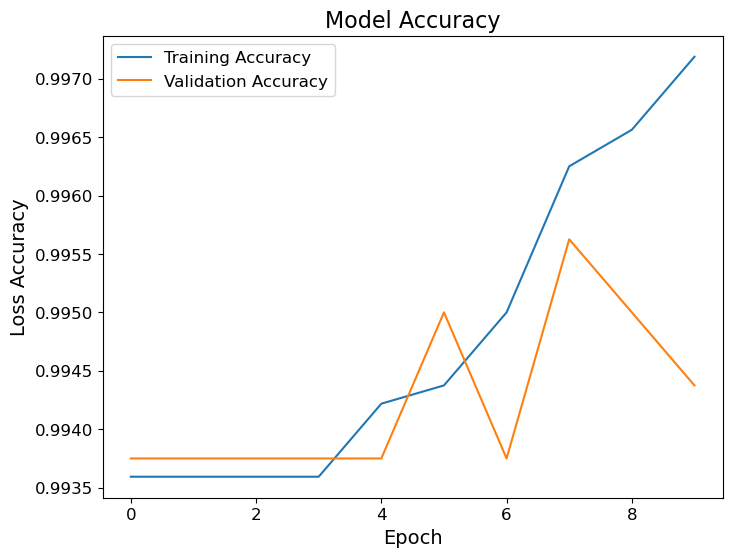

In [7]:
# Plot the loss and accuracy
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_title('Model Loss', fontsize=16)
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)
plt.show()

# Plot the loss and accuracy
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(history.history['accuracy'], label='Training Accuracy')
ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax.set_title('Model Accuracy', fontsize=16)
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss Accuracy', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)
plt.show()

In [8]:
# Set batch size and number of chunks
batch_size = 8
num_chunks = 30

# Split train data and demographic variables into chunks
chunk_size = len(x_train) // num_chunks
train_chunks = [x_train[i:i+chunk_size] for i in range(0, len(x_train), chunk_size)]
dv_chunks = [dv_train[i:i+chunk_size] for i in range(0, len(dv_train), chunk_size)]

# Get predictions for each chunk of data
predictions = []
for i, chunk in enumerate(train_chunks):
    dv_chunk = dv_chunks[i]
    chunk_predictions = model.predict([chunk, dv_chunk], batch_size=batch_size)
    predictions.append(chunk_predictions)

# Concatenate predictions from all chunks
predictions = np.concatenate(predictions, axis=0)

preds = np.copy(predictions)
preds = np.squeeze(preds)

# Find the F1 score for different threshold values
thresholds = np.arange(0, 1, 0.01)
f1_scores = [f1_score(y_train, (preds > t).astype(int), average='weighted') for t in thresholds]

# Find the threshold value that maximizes the F1 score
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print("Best threshold:" ,best_threshold)

2/2 [==============================] - 0s 5ms/step
Best threshold: 0.07


In [9]:
# Get the prediction for some samples in the test set
sample = test_input[np.where(test_target==1)[0]]
dv_sample = test_dv[np.where(test_target==1)[0]]

prediction = model.predict([np.array(sample), dv_sample])

# Print the prediction
print('Prediction:', prediction)

1/1 [==============================] - 0s 38ms/step
Prediction: [[1.6401657e-01]
 [5.4658622e-01]
 [2.5121710e-05]
 [1.9322389e-01]
 [9.0623963e-01]
 [8.5402928e-02]
 [5.4658622e-01]
 [3.0695594e-06]
 [2.7189057e-02]
 [5.4387689e-01]
 [5.6839148e-03]
 [2.7189057e-02]
 [7.4108166e-04]]


3/3 [==============================] - 0s 5ms/step


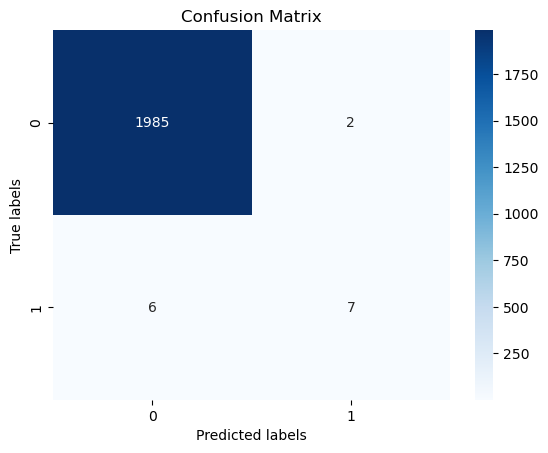

AUC: 0.7687
Precision with recall set to 0.9: 0.7778


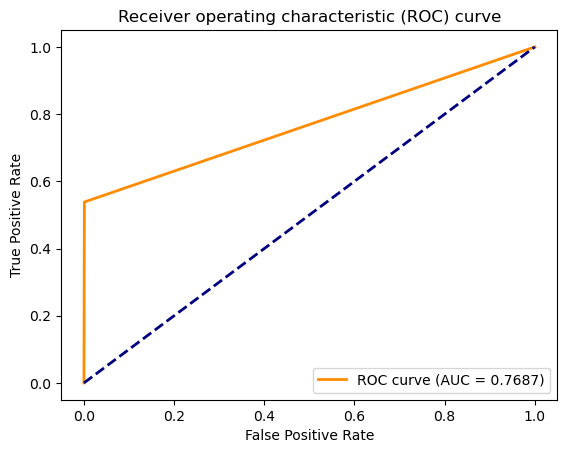

In [10]:
# Set batch size and number of chunks
batch_size = 8
num_chunks = 30

# Split test data and demographic variables into chunks
chunk_size = len(test_input) // num_chunks
test_chunks = [test_input[i:i+chunk_size] for i in range(0, len(test_input), chunk_size)]
dv_chunks = [test_dv[i:i+chunk_size] for i in range(0, len(test_dv), chunk_size)]

# Get predictions for each chunk of data
predictions = []
for i, chunk in enumerate(test_chunks):
    dv_chunk = dv_chunks[i]
    chunk_predictions = model.predict([chunk, dv_chunk], batch_size=batch_size)
    predictions.append(chunk_predictions)

# Concatenate predictions from all chunks
predictions = np.concatenate(predictions, axis=0)

# Convert the continuous predictions to binary classes
preds = np.copy(predictions)
preds = [1 if y > best_threshold else 0 for y in preds]

# Compute the confusion matrix
cm = confusion_matrix(test_target, preds)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# Add labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


# Compute the AUC
auc_score = roc_auc_score(test_target, preds)
print("AUC: {:.4f}".format(auc_score))

# Compute the precision with recall set to 0.9
precision, recall, thresholds = precision_recall_curve(test_target, preds)
idx = (recall >= 0.9).argmin()
precision_at_recall_09 = precision[idx]
print("Precision with recall set to 0.9: {:.4f}".format(precision_at_recall_09))

# Compute the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(test_target, preds)

# Compute the area under the curve (AUC)
roc_auc_curve = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.4f})'.format(roc_auc_curve))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc='lower right')
plt.show()
